In [ ]:
# code modified from:
# https://github.com/sweat0198/audio_classification_CNN_ESC-50/blob/master/esc-50-keras.ipynb

# Audio classification with deep learning


## Preparation for deep learning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
##
import numpy as np
from tqdm import tqdm
freq = 128
time = 1723

In [ ]:
# dataset files are available on https://www.kaggle.com/tubistaj/esc50aug
files_dir = './drive/MyDrive/HDA_project/'
train_files = [
               files_dir + "esc_melsp_train_raw.npz",
              #  files_dir + "esc_melsp_train_ss.npz",
              #  files_dir + "esc_melsp_train_st.npz",
              #  files_dir + "esc_melsp_train_wn.npz",
              #  files_dir + "esc_melsp_train_com.npz"
               ]
test_file = files_dir + "esc_melsp_test.npz"

In [ ]:
train_num = 1500 ##
test_num = 500 ##

In [ ]:
##

import psutil

def print_memory():

    # Get memory usage
    memory = psutil.virtual_memory()

    # Print memory usage statistics
    # print("Total Memory:", memory.total)
    # print("Available Memory:", memory.available)
    # print("Used Memory:", memory.used)
    # print("Free Memory:", memory.free)
    print("Memory Usage Percentage:", memory.percent)

In [ ]:
print_memory()

# define dataset placeholders
# the original dtype was float64, but since it exceeded memory it converted to float32
x_train = np.zeros(freq*time*train_num*len(train_files), dtype='float32').reshape(train_num*len(train_files), freq, time)
y_train = np.zeros(train_num*len(train_files), dtype='float32')

# load dataset
n = len(train_files) ##
for i in tqdm(range(n)):
    print_memory()
    data = np.load(train_files[i])
    x_train[i*train_num:(i+1)*train_num] = data["x"]
    y_train[i*train_num:(i+1)*train_num] = data["y"]

Memory Usage Percentage: 14.0


  0%|          | 0/1 [00:00<?, ?it/s]

Memory Usage Percentage: 14.0


100%|██████████| 1/1 [00:27<00:00, 27.56s/it]


In [ ]:
# load test dataset
test_data = np.load(test_file)
x_test = test_data["x"]
y_test = test_data["y"]

In [ ]:
##
import os
import keras
from sklearn import model_selection
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation
from keras.layers import Conv2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Add
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model


In [ ]:
# redefine target data into one hot vector
classes = 50
y_train = keras.utils.to_categorical(y_train, classes)
y_test = keras.utils.to_categorical(y_test, classes)

In [ ]:
# reshape training dataset
x_train = x_train.reshape(train_num*len(train_files), freq, time, 1)
x_test = x_test.reshape(test_num, freq, time, 1)

In [ ]:
x_test, x_val, y_test, y_val= model_selection.train_test_split(x_test, y_test, test_size=3/5, random_state=1)

In [ ]:

print("x train:{0}\ny train:{1}\nx val:{2}\ny val:{3}\nx test:{4}\ny test:{5}".format(x_train.shape,
                                                                                      y_train.shape,
                                                                                      x_val.shape,
                                                                                      y_val.shape,
                                                                                      x_test.shape,
                                                                                      y_test.shape))

x train:(1500, 128, 1723, 1)
y train:(1500, 50)
x val:(300, 128, 1723, 1)
y val:(300, 50)
x test:(200, 128, 1723, 1)
y test:(200, 50)


## Define convolutional neural network

In [ ]:
def cba(inputs, filters, kernel_size, strides):
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [ ]:
# define CNN
inputs = Input(shape=(x_train.shape[1:]))

x_1 = cba(inputs, filters=32, kernel_size=(1,8), strides=(1,2))
x_1 = cba(x_1, filters=32, kernel_size=(8,1), strides=(2,1))
x_1 = cba(x_1, filters=64, kernel_size=(1,8), strides=(1,2))
x_1 = cba(x_1, filters=64, kernel_size=(8,1), strides=(2,1))

x_2 = cba(inputs, filters=32, kernel_size=(1,16), strides=(1,2))
x_2 = cba(x_2, filters=32, kernel_size=(16,1), strides=(2,1))
x_2 = cba(x_2, filters=64, kernel_size=(1,16), strides=(1,2))
x_2 = cba(x_2, filters=64, kernel_size=(16,1), strides=(2,1))

x_3 = cba(inputs, filters=32, kernel_size=(1,32), strides=(1,2))
x_3 = cba(x_3, filters=32, kernel_size=(32,1), strides=(2,1))
x_3 = cba(x_3, filters=64, kernel_size=(1,32), strides=(1,2))
x_3 = cba(x_3, filters=64, kernel_size=(32,1), strides=(2,1))

x_4 = cba(inputs, filters=32, kernel_size=(1,64), strides=(1,2))
x_4 = cba(x_4, filters=32, kernel_size=(64,1), strides=(2,1))
x_4 = cba(x_4, filters=64, kernel_size=(1,64), strides=(1,2))
x_4 = cba(x_4, filters=64, kernel_size=(64,1), strides=(2,1))

x = Add()([x_1, x_2, x_3, x_4])

x = cba(x, filters=128, kernel_size=(1,16), strides=(1,2))
x = cba(x, filters=128, kernel_size=(16,1), strides=(2,1))

x = GlobalAveragePooling2D()(x)
x = Dense(classes)(x)
x = Activation("softmax")(x)

model = Model(inputs, x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 1723, 1)]       0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 862, 32)         288       ['input_1[0][0]']             
                                                                                                  
 conv2d_4 (Conv2D)           (None, 128, 862, 32)         544       ['input_1[0][0]']             
                                                                                                  
 conv2d_8 (Conv2D)           (None, 128, 862, 32)         1056      ['input_1[0][0]']             
                                                                                              

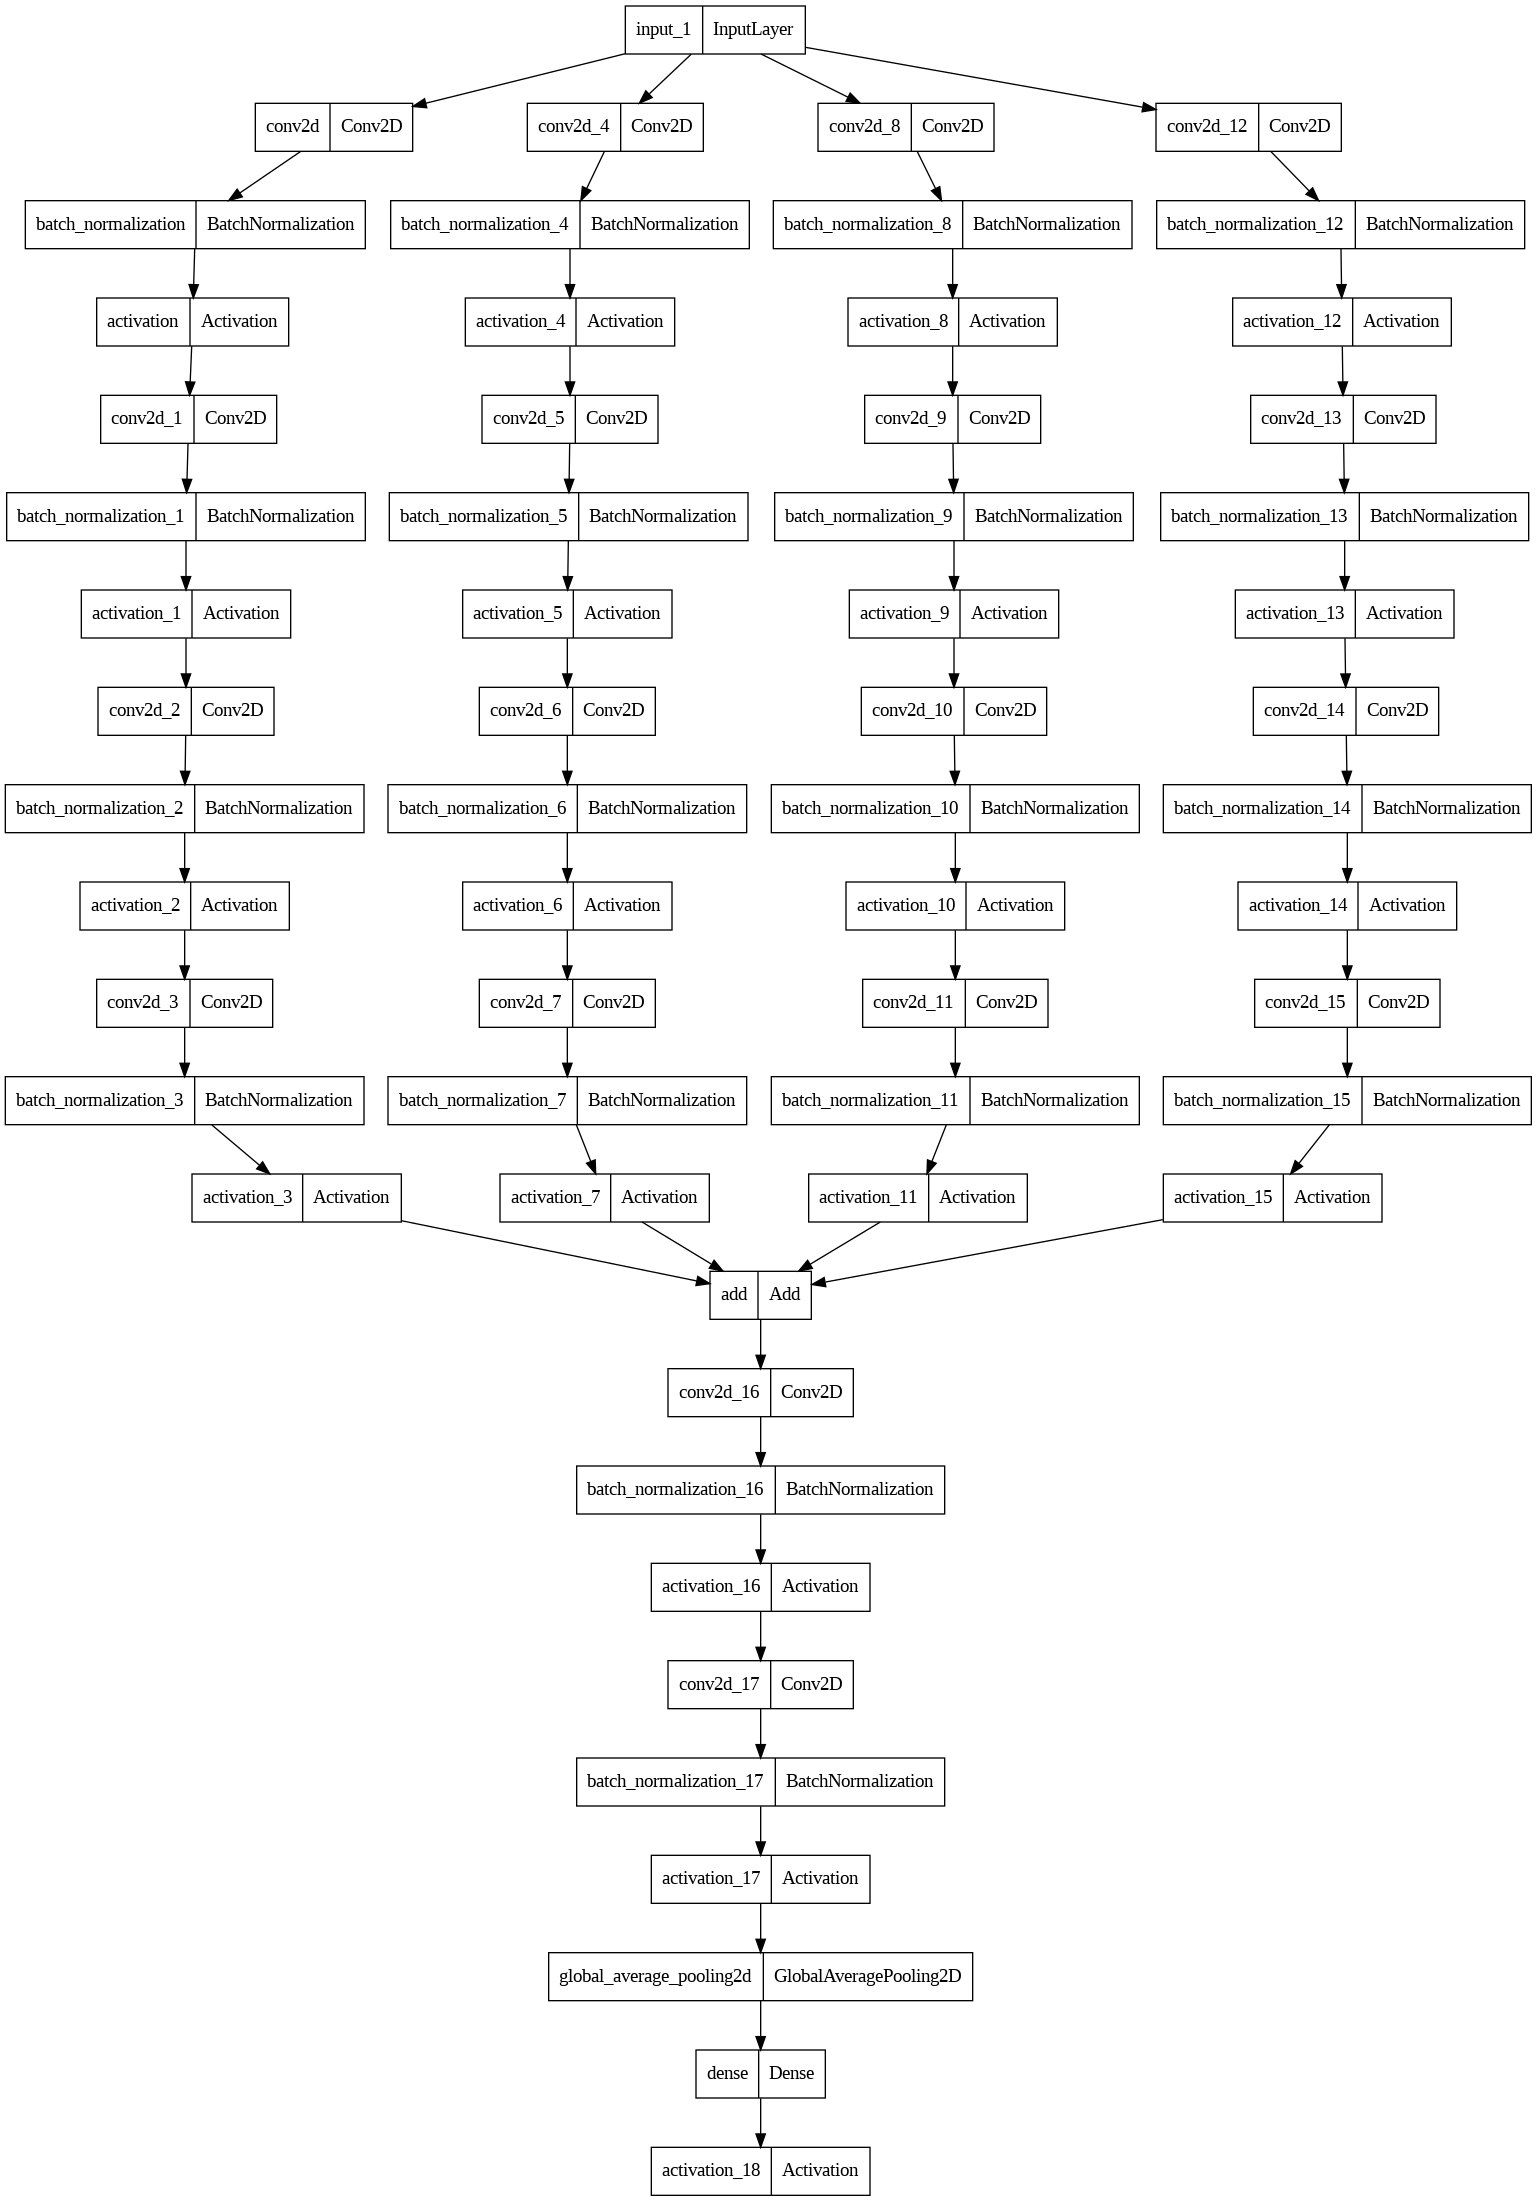

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png')

## Optimization and callbacks

In [ ]:
# initiate Adam optimizer
opt = keras.optimizers.Adam(lr=0.00005, amsgrad=True)

# Let's train the model using Adam with amsgrad
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['acc'])

In [ ]:
# directory for model checkpoints
model_dir = "./drive/MyDrive/HDA_project/models"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

## Train CNN model with between class dataset

In [ ]:
import tensorflow as tf

batch_size = 16
epochs = 20

model = tf.keras.models.load_model(model_dir + '/model_5.hdf5')

chkpt = os.path.join(model_dir, 'model_5_1.hdf5')
cp_cb = ModelCheckpoint(filepath = chkpt, verbose=1, save_best_only = True)

model.fit(x_train,
          y_train,
          validation_data = (x_val, y_val),
          epochs = epochs,
          batch_size = batch_size,
          callbacks = [cp_cb],
          shuffle = True)

Epoch 1/20
94/94 [==============================] - ETA: 0s - loss: 0.2963 - acc: 0.9220
Epoch 1: val_loss improved from inf to 1.28254, saving model to ./drive/MyDrive/HDA_project/models/model_5_1.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


94/94 [==============================] - 184s 2s/step - loss: 0.2963 - acc: 0.9220 - val_loss: 1.2825 - val_acc: 0.7667
Epoch 2/20
94/94 [==============================] - ETA: 0s - loss: 0.1120 - acc: 0.9687
Epoch 2: val_loss improved from 1.28254 to 0.64464, saving model to ./drive/MyDrive/HDA_project/models/model_5_1.hdf5
94/94 [==============================] - 123s 1s/step - loss: 0.1120 - acc: 0.9687 - val_loss: 0.6446 - val_acc: 0.8600
Epoch 3/20
94/94 [==============================] - ETA: 0s - loss: 0.0797 - acc: 0.9847
Epoch 3: val_loss improved from 0.64464 to 0.46059, saving model to ./drive/MyDrive/HDA_project/models/model_5_1.hdf5
94/94 [==============================] - 124s 1s/step - loss: 0.0797 - acc: 0.9847 - val_loss: 0.4606 - val_acc: 0.8700
Epoch 4/20
94/94 [==============================] - ETA: 0s - loss: 0.0631 - acc: 0.9873
Epoch 4: val_loss improved from 0.46059 to 0.36827, saving model to ./drive/MyDrive/HDA_project/models/model_5_1.hdf5
94/94 [============

## Evaluate model

In [ ]:
os.listdir('drive/MyDrive/HDA_project/')

['data',
 'esc_melsp_test.npz',
 'esc_melsp_train_raw.npz',
 'esc_melsp_train_wn.npz',
 'esc_melsp_train_ss.npz',
 'esc_melsp_train_st.npz',
 'esc_melsp_train_com.npz',
 'models',
 'models4',
 'model4.ipynb',
 'models4_esc10',
 'models3_esc10',
 'model4_esc10.ipynb',
 'model_evaluation_metrics.ipynb',
 'model3.ipynb']

In [ ]:
model = load_model(model_dir + '/model_5_1.hdf5')
test_data = np.load('drive/MyDrive/HDA_project/esc_melsp_test.npz')
x_test = test_data["x"]
y_test = test_data["y"]

In [ ]:
# x_test = x_test[:,:,:,None]
y_test = keras.utils.to_categorical(y_test, classes)

In [ ]:
print(x_test.shape)
print(y_test.shape)

(500, 128, 1723)
(500, 50)


In [ ]:
evaluation = model.evaluate(x_test, y_test)
print(evaluation)

16/16 [==============================] - 19s 1s/step - loss: 0.3096 - acc: 0.9140
[0.3096131384372711, 0.9139999747276306]
